### Imports

In [ ]:
!pip install -q comet_ml

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.1.0 is successfully installed


In [ ]:
!pip install -q timm

     |████████████████████████████████| 376 kB 10.0 MB/s 


In [ ]:
from comet_ml import Experiment
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import timm
from pprint import pprint

from torchvision import transforms
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2

from sklearn.metrics import balanced_accuracy_score, average_precision_score, precision_score, recall_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset

In [ ]:
deers_train_root = '/content/drive/MyDrive/rosneft_hack/data/deers/train'
deers_test_root = '/content/drive/MyDrive/rosneft_hack/data/deers/test'

transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.4, hue=0.1)
])

In [ ]:
class Transforms:
    
    def __init__(
        self,
        transforms: A.Compose,
    ) -> None:
        
        self.transforms = transforms

    def __call__(
        self,
        img,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        
        return self.transforms(image=np.array(img))['image']

In [ ]:
transform_train = A.Compose([
        A.LongestMaxSize(max_size=224),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
        A.PadIfNeeded(
            position=A.PadIfNeeded.PositionType.CENTER,
            min_height=224,
            min_width=224,
            value=0,
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.Affine(scale=[0.5, 1.5], rotate=30, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.4, hue=0.1),
        ToTensorV2(),
])
transform_test = A.Compose([
        A.LongestMaxSize(max_size=224),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
        A.PadIfNeeded(
            position=A.PadIfNeeded.PositionType.CENTER,
            min_height=224,
            min_width=224,
            value=0,
            border_mode=cv2.BORDER_CONSTANT,
        ),
        ToTensorV2(),
])

In [ ]:
deers_train = ImageFolder(deers_train_root, transform=Transforms(transform_train))
deers_test = ImageFolder(deers_test_root, transform=Transforms(transform_test))

In [ ]:
len(deers_train), len(deers_test)

(21720, 3169)

### Dataloader

In [ ]:
BATCH_SIZE = 64
train_dataloader = DataLoader(deers_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(deers_test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
res =next(iter(test_dataloader))

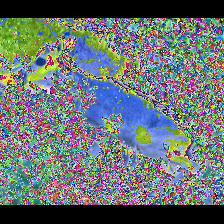

In [ ]:
transforms.ToPILImage()(res[0][0])

### Model

#### Resnet50

In [ ]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
model.fc.in_features

2048

In [ ]:
model.eval()
for param in model.parameters():
    param.requires_grad_(False)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=2)
model.fc.requires_grad_(True)

Linear(in_features=2048, out_features=2, bias=True)

In [ ]:
model

#### Timm 

In [ ]:
model_names = timm.list_models(pretrained=True)
# pprint(model_names)

In [158]:
model = timm.create_model('vit_small_patch16_224_in21k', pretrained=True)

In [159]:
model.train()
for param in model.parameters():
    param.requires_grad_(True)
model.head = nn.Linear(in_features=model.head.in_features, out_features=2)
model.head.requires_grad_(True)

Linear(in_features=384, out_features=2, bias=True)

### Now let's train the model

In [160]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [161]:
loss_func = nn.CrossEntropyLoss(weight=torch.tensor([10., 1.])).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-05.


In [162]:
_ = model.to(device)

In [163]:
best_test_acc = 0
best_test_epoch = 0

In [164]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='rosneft-deer-classification',
                        workspace='alexandernevarko')

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/rosneft-deer-classification/c4317e1d9f0b42fd8dd9f7a9a24ee5ea
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [547]                    : (0.034417830407619476, 1.030423641204834)
COMET INFO:     test fawn precision [16]      : (0.35591836734693877, 0.7618213660245184)
COMET INFO:     test fawn recall [16]         : (0.9175475687103594, 0.9365750528541226)
COMET INFO:     test reindeer precision [16]  : (0.9809670781893004, 0.9879614767255217)
COMET INFO:     test reindeer recall [16]     : (0.7073442136498517, 0.9495548961424333)
COMET INFO:     test_loss [16]                : (0.1519687215052545, 0.5272362896800041)
COMET INFO:     train fawn precision [16]     : (0.23375759088262207, 0.6735794276233927)
COMET INFO:

In [165]:
softmax = nn.Softmax(dim=1)

In [ ]:
n_epochs = 30
epoch_train_loss = []
epoch_test_loss = []
experiment.set_name('finetuneall_vit_small_patch16_224_in21k_20_epochs_new_strategy')
for epoch in range(n_epochs):
    running_loss = []
    true_target = []
    pred_target = []
    
    running_test_loss = []
    true_test_target = []
    pred_test_target = []

    model.train()
    for img, target in tqdm(train_dataloader):
        img, target = img.to(device).float(), target.to(device)
        optimizer.zero_grad()
        preds = model(img).float()
        loss = loss_func(preds, target)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        preds = softmax(preds)
        pred_target.extend(list(preds.detach().cpu().numpy()))
        true_target.extend(list(target.detach().cpu().numpy()))
    scheduler.step()
    model.eval()
    for img, target in tqdm(test_dataloader):
        img, target = img.to(device).float(), target.to(device)
        preds = model(img).float()
        loss = loss_func(preds, target)
        
        running_test_loss.append(loss.item())
        preds = softmax(preds)
        pred_test_target.extend(list(preds.detach().cpu().numpy()))
        true_test_target.extend(list(target.detach().cpu().numpy()))
    

    pred_target = np.asarray(pred_target)
    true_target = np.asarray(true_target)
    pred_test_target = np.asarray(pred_test_target)
    true_test_target = np.asarray(true_test_target)
    
    experiment.log_metric('train_loss', np.mean(running_loss), epoch=epoch, step=epoch)
    experiment.log_metric('test_loss', np.mean(running_test_loss), epoch=epoch, step=epoch)
    experiment.log_metric('test_fawn_recall', recall_score(1-true_test_target, 1-pred_test_target.argmax(axis=1)), 
                          epoch=epoch, step=epoch)
    experiment.log_metric('test_fawn_precision', precision_score(1-true_test_target, 1-pred_test_target.argmax(axis=1)), 
                          epoch=epoch, step=epoch)
    experiment.log_metric('test_reindeer_recall', recall_score(true_test_target, pred_test_target.argmax(axis=1)), 
                          epoch=epoch, step=epoch)
    experiment.log_metric('test_reindeer_precision', precision_score(true_test_target, pred_test_target.argmax(axis=1)), 
                          epoch=epoch, step=epoch)
    
    experiment.log_metric('train_fawn_recall', recall_score(1-true_target, 1-pred_target.argmax(axis=1)), 
                          epoch=epoch, step=epoch)
    experiment.log_metric('train_fawn_precision', precision_score(1-true_target, 1-pred_target.argmax(axis=1)), 
                          epoch=epoch, step=epoch)
    experiment.log_metric('train_reindeer_recall', recall_score(true_target, pred_target.argmax(axis=1)), 
                          epoch=epoch, step=epoch)
    experiment.log_metric('train_reindeer_precision', precision_score(true_target, pred_target.argmax(axis=1)), 
                          epoch=epoch, step=epoch)

    print(f'Epoch {epoch} mean train loss {np.mean(running_loss)}')
    print(f'Epoch {epoch} mean test loss {np.mean(running_test_loss)}')
    # print(f'Epoch {epoch} train balanced accuracy {balanced_accuracy_score(true_target, pred_target)}')
    # print(f'Epoch {epoch} test balanced accuracy {balanced_accuracy_score(true_test_target, pred_test_target)}')
    epoch_train_loss.append(np.mean(running_loss))
    epoch_test_loss.append(np.mean(running_test_loss))
    torch.save(model.state_dict(), f'/content/drive/MyDrive/rosneft_hack/models/deers_timm_vit_all.pth')

  0%|          | 0/340 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 mean train loss 0.2896304617690689
Epoch 0 mean test loss 0.20533517614006996


  0%|          | 0/340 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 mean train loss 0.16965555869700277
Epoch 1 mean test loss 0.2096203016396612


  0%|          | 0/340 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 mean train loss 0.1418978821979288
Epoch 2 mean test loss 0.19238404005765916


  0%|          | 0/340 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 mean train loss 0.129280315082082
Epoch 3 mean test loss 0.18759048984386026


  0%|          | 0/340 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 mean train loss 0.11343768528279136
Epoch 4 mean test loss 0.13561818751972168


  0%|          | 0/340 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 mean train loss 0.10819706226534703
Epoch 5 mean test loss 0.17072780264541507


  0%|          | 0/340 [00:00<?, ?it/s]

In [134]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/rosneft_hack/models/deers_all_vit_small_patch16_224_in21k_best.pth')

### Evaluate

In [135]:
running_test_loss = []
true_test_target = []
pred_test_target = []

model.eval()
for img, target in tqdm(test_dataloader):
    img, target = img.to(device).float(), target.to(device)
    preds = model(img)
    loss = loss_func(preds, target)
    
    running_test_loss.append(loss.item())
    preds = softmax(preds)
    pred_test_target.extend(list(preds.detach().cpu().numpy()))
    true_test_target.extend(list(target.detach().cpu().numpy()))

  0%|          | 0/50 [00:00<?, ?it/s]

In [136]:
pred_test_target = np.asarray(pred_test_target)
true_test_target = np.asarray(true_test_target)

In [148]:
recall_score(1-true_test_target, 1-pred_test_target.argmax(axis=1))

0.9112050739957717

In [147]:
precision_score(1-true_test_target, 1-pred_test_target.argmax(axis=1))

0.8654618473895582

In [142]:
balanced_accuracy_score(true_test_target, pred_test_target.argmax(axis=1))

0.943176720974147

In [140]:
average_precision_score(true_test_target, pred_test_target[:, 0])

0.6694702008080693

In [141]:
average_precision_score(true_test_target, pred_test_target[:, 1])

0.9963457712379894

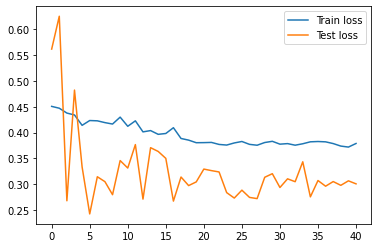

In [ ]:
plt.plot(epoch_train_loss, label='Train loss')
plt.plot(epoch_test_loss, label='Test loss')
plt.legend()
plt.show()

In [ ]:
import os

model.eval()
res = {'filename':[], 'tail': []}
transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
for img_name in tqdm(os.listdir('/content/drive/MyDrive/liders_hack/datasets/test/dogs')):
    img = Image.open(os.path.join('/content/drive/MyDrive/liders_hack/datasets/test/dogs', img_name))
    img = transform(img).view(1, 3, 224, 224).to(device)
    preds = model(img)
    preds = torch.argmax(preds, dim=1)[0].item()
    res['filename'].append(img_name)
    res['tail'].append(preds)

  0%|          | 0/185 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(res)
df
df.to_csv('/content/drive/MyDrive/liders_hack/models/tails_test.csv')